# Modelling 

We will do the following:

- Combine the two datasets with one row being one player per game.
- Build a classification model using prepared data.
- Validate model(s) & perform some tuning (use metrics such as ROC curve for this)
- Pick the best performant model & params to take to production.

### First let's import the timelines data and create our features that we derived from the Data Exploration Notebook

In [376]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc, balanced_accuracy_score, confusion_matrix
import xgboost as xgb
import shap
import pickle

In [3]:
timeline = pd.read_csv('./match-data/parsed-timelines/timeline.csv')

## construct feature 1

In [15]:
feature_1 = timeline.loc[timeline['type'] == 'BUILDING_KILL'].groupby(['matchId', 'id'])[['timestamp']].mean()
feature_1.rename(columns={'timestamp' : 'building_kill_avg_timestamp'}, inplace=True)
feature_1.reset_index(inplace=True)

feature_1.head()

,matchId,id,building_kill_avg_timestamp
0,EUN1_2975183783,HEcLe8Gzo1Th6ql1m8lbuO3XjTNiOUeqWZiCn9f-wIw4UO...,1692227.0
1,EUN1_2981471732,HEcLe8Gzo1Th6ql1m8lbuO3XjTNiOUeqWZiCn9f-wIw4UO...,1354358.0
2,EUN1_3000834835,HEcLe8Gzo1Th6ql1m8lbuO3XjTNiOUeqWZiCn9f-wIw4UO...,1263432.0
3,EUW1_5264151691,aT2O38ePi0jbq-4NGQxddD2annTqPdQlCTTpKTDOW7nu926k,1086610.0
4,EUW1_5275954798,foIeyqeOJOcS4zcSufbk93ur5tzA2lKx5MnMq4czciQk2kI,942676.5


In [17]:
## construct feature 2

timeline_jungle = timeline.loc[((timeline['x'] > 5000/1.08) & 
                              (timeline['x'] < 11000/1.08) & 
                              (timeline['y'] > 2000/1.08) & 
                              (timeline['y'] < 5000/1.08)) |
                              ((timeline['x'] < 14000/1.08) & 
                              (timeline['x'] > 11000/1.08) & 
                              (timeline['y'] > 5000/1.08) & 
                              (timeline['y'] < 11000/1.08))]

timeline_jungle = timeline_jungle.loc[timeline_jungle['type'] == 'CHAMPION_DEATH'].reset_index(drop=True)

feature_2 = timeline_jungle.groupby(['matchId', 'id'])[['timestamp']].mean()
feature_2.rename(columns={'timestamp' : 'jungle_death_average_timestamp'}, inplace=True)
feature_2.reset_index(inplace=True)

feature_2.head()

,matchId,id,jungle_death_average_timestamp
0,EUN1_3000834835,HEcLe8Gzo1Th6ql1m8lbuO3XjTNiOUeqWZiCn9f-wIw4UO...,1597043.0
1,EUW1_5187042587,P764fRIDEZWPQzPYvlshHF9167dcG1gCnosbW4rQWhgkRe...,772960.0
2,EUW1_5275889820,foIeyqeOJOcS4zcSufbk93ur5tzA2lKx5MnMq4czciQk2kI,356417.0
3,EUW1_5277175040,foIeyqeOJOcS4zcSufbk93ur5tzA2lKx5MnMq4czciQk2kI,1094294.0
4,EUW1_5277323455,foIeyqeOJOcS4zcSufbk93ur5tzA2lKx5MnMq4czciQk2kI,971965.0


## construct feature 3

In [9]:
feature_3 = timeline.groupby(['matchId', 'id'])[['timestamp']].count().rename(columns={'timestamp' : 'activity'})
feature_3.reset_index(inplace = True)

feature_3.head()

,matchId,id,activity
0,EUN1_2975183783,HEcLe8Gzo1Th6ql1m8lbuO3XjTNiOUeqWZiCn9f-wIw4UO...,19
1,EUN1_2980508604,HEcLe8Gzo1Th6ql1m8lbuO3XjTNiOUeqWZiCn9f-wIw4UO...,7
2,EUN1_2981471732,HEcLe8Gzo1Th6ql1m8lbuO3XjTNiOUeqWZiCn9f-wIw4UO...,22
3,EUN1_3000834835,HEcLe8Gzo1Th6ql1m8lbuO3XjTNiOUeqWZiCn9f-wIw4UO...,27
4,EUW1_5185117699,P764fRIDEZWPQzPYvlshHF9167dcG1gCnosbW4rQWhgkRe...,6


# Merge features with summaries dataset

In [18]:
summaries = pd.read_csv('./match-data/parsed-summaries/summary.csv')

In [27]:
print(f'shape of summaries data is: {summaries.shape}')

with pd.option_context('display.max_rows', 5, 'display.max_columns', None):
    display(summaries.head())

shape of summaries data is: (519230, 108)


,assists,baronKills,bountyLevel,champExperience,champLevel,championId,championName,championTransform,consumablesPurchased,damageDealtToBuildings,damageDealtToObjectives,damageDealtToTurrets,damageSelfMitigated,deaths,detectorWardsPlaced,doubleKills,dragonKills,firstBloodAssist,firstBloodKill,firstTowerAssist,firstTowerKill,gameDuration,gameEndedInEarlySurrender,gameEndedInSurrender,gameStart,goldEarned,goldSpent,individualPosition,inhibitorKills,inhibitorTakedowns,inhibitorsLost,item0,item1,item2,item3,item4,item5,item6,itemsPurchased,killingSprees,kills,lane,largestCriticalStrike,largestKillingSpree,largestMultiKill,longestTimeSpentLiving,magicDamageDealt,magicDamageDealtToChampions,magicDamageTaken,matchId,neutralMinionsKilled,nexusKills,nexusLost,nexusTakedowns,objectivesStolen,objectivesStolenAssists,participantId,pentaKills,physicalDamageDealt,physicalDamageDealtToChampions,physicalDamageTaken,profileIcon,puuid,quadraKills,riotIdName,riotIdTagline,role,sightWardsBoughtInGame,spell1Casts,spell2Casts,spell3Casts,spell4Casts,summoner1Casts,summoner1Id,summoner2Casts,summoner2Id,summonerId,summonerLevel,summonerName,teamEarlySurrendered,teamId,teamPosition,timeCCingOthers,timePlayed,totalDamageDealt,totalDamageDealtToChampions,totalDamageShieldedOnTeammates,totalDamageTaken,totalHeal,totalHealsOnTeammates,totalMinionsKilled,totalTimeCCDealt,totalTimeSpentDead,totalUnitsHealed,tripleKills,trueDamageDealt,trueDamageDealtToChampions,trueDamageTaken,turretKills,turretTakedowns,turretsLost,unrealKills,visionScore,visionWardsBoughtInGame,wardsKilled,wardsPlaced,win,pro_flag
0,0,0,0,7766,11,86,Garen,0,2,817.0,817,817,11881,3,0,0,0,False,False,False,False,1061,False,True,1642620163907,5567,5100,TOP,0,0.0,0.0,6631,1054,0,3006,0,0,3340,13,1,2,NONE,0,2,1,438,0,0,4532,EUW1_5677892892,0,0,0.0,0.0,0,0,1,0,45056,4882,8047,5212,LbNsNJcAUBOpDuV9vXj0OZJaZdl1KCn7-cqM9854d-ryhZ...,0,NaN,NaN,SUPPORT,0,40,18,35,2,1,12,1,4,j4QBUANVrv1WpTrg_VTGYqMx-wY4O_TUbFcvSNo4DB_DBgo,431,sandyio,False,100,TOP,10,1061,48589,5695,0,12580,361,0,112,61,81,1,0,3533,813,0,0,0.0,4.0,0,8,0,0,6,False,0
1,3,0,0,7691,11,120,Hecarim,0,3,0.0,5026,0,10093,3,3,0,0,False,False,False,False,1061,False,True,1642620163907,6358,5975,JUNGLE,0,0.0,0.0,3133,3070,6664,3158,0,0,3364,17,0,2,NONE,138,0,1,405,23022,1113,6451,EUW1_5677892892,106,0,0.0,0.0,0,0,2,0,67796,4293,9953,4630,82nYwIs5IY0L_-yS5a4q73E8IlUerZXr3hFcBTZR3OqFpM...,0,NaN,NaN,SUPPORT,0,172,40,31,3,4,6,11,11,jZb9aNNy07A_APJv3iN2WStWxnbP7yacihMeNDvwuCZu3aze,326,why do i pIay,False,100,JUNGLE,9,1061,96429,6169,0,16563,8004,0,16,125,71,1,0,5611,763,158,0,0.0,4.0,0,17,3,3,4,False,0
2,0,0,0,6429,10,45,Veigar,0,1,0.0,0,0,3238,8,0,0,0,False,False,False,False,1061,False,True,1642620163907,4784,4675,MIDDLE,0,0.0,0.0,1082,6656,2033,2055,3158,0,3340,11,0,1,NONE,0,0,1,269,33859,3475,7406,EUW1_5677892892,0,0,0.0,0.0,0,0,3,0,5587,1311,2779,1391,nUIXB26-mpQpeOHuQ46jtkXpyNrYSmaLX0zEZ25nkSoj2f...,0,NaN,NaN,SUPPORT,0,65,36,11,3,3,4,2,12,-rG6rBK2ejhceTs9PqKI3cyl8Aym8_Lpj0DWsNvBm1vca8c,245,Korvish,False,100,MIDDLE,1,1061,39447,4786,0,10210,1400,0,101,31,135,1,0,0,0,24,0,0.0,4.0,0,4,1,0,5,False,0
3,2,0,0,5948,9,222,Jinx,0,8,2328.0,3163,2328,2358,4,4,0,0,False,False,False,False,1061,False,True,1642620163907,6360,6200,BOTTOM,0,0.0,0.0,2031,0,6672,1036,1036,3006,3363,21,0,1,NONE,323,0,1,706,146,146,5938,EUW1_5677892892,2,0,0.0,0.0,0,0,4,0,57269,4161,2353,7,bEyq9XCl1X8mzMSga8pgG12YwxbgYkN7UOXjD_RAP325vM...,0,NaN,NaN,DUO,0,74,31,9,3,3,4,3,7,FouVwcASV7gKCnZkg6ht77N9RPzE_4a9QuHTqqdr8u6Ni4...,45,XBredi Jr,False,100,BOTTOM,5,1061,58840,4408,0,8292,801,345,135,21,115,3,0,1424,100,0,1,1.0,4.0,0,15,4,2,9,False,0
4,3,0,0,5016,8,26,Zilean,0,5,993.0,1208,993,1847,3,2,0,0,False,False,True,False,1061,False,True,1642620163907,4283,3525,UTILITY,0,0.0,0.0,2003,3851,2055,2422,4644,0,3364,12,0,0,NONE,0,0,0,490,11281,2637,2742,EUW1_5677892892,0,0,0.0,0.0,0,0,5,0,1763,349,2932,22,r-GyqrnH_abnEg2ZbQHHnfiQZwTFt5jaRWuCeFi7fEffNi...,0,NaN,NaN,SUPPORT,0,78,30,45,2,2,4,1,14,z

In [40]:
# merge in feature 1 and see how many rows affected

summaries_ft1 = pd.merge(summaries, feature_1, 
         left_on=['matchId', 'summonerId'], right_on=['matchId', 'id'],
         how='left').drop(columns='id')
summaries_ft1.loc[summaries_ft1['building_kill_avg_timestamp'].notnull()].shape

(24584, 109)

In [41]:
# merge in feature 2 and print shape

summaries_ft12 = pd.merge(summaries_ft1, feature_2, 
                         left_on=['matchId', 'summonerId'], right_on=['matchId', 'id'],
                         how='left').drop(columns='id')
summaries_ft12.loc[summaries_ft12['jungle_death_average_timestamp'].notnull()].shape

(19472, 110)

In [42]:
# merge in feature 3 and print shape

summaries_full = pd.merge(summaries_ft12, feature_3, 
                         left_on=['matchId', 'summonerId'], right_on=['matchId', 'id'],
                         how='left').drop(columns='id')
summaries_full.loc[summaries_ft123['activity'].notnull()].shape

(48229, 111)

A note: merging separately like this is a RAM intensive process; one copy of the entire dataset has been made 4 times now (each sumarries dataset is 290mb. This is not an issue for my laptop but I'm aware that if this dataset scaled we'd have to take a different approach - a quick win would be to reassign each feature to the same dataframe, but this increases chances of mistakes. Since we're not bottlenecked here I've gone with this style)

Since we had to take a subset of the timeline data (due to the amount of time it was taking to download all timelines) we have 20-50k non-null entries in the summaries dataset with 500k rows. This means values are mostly null.

In the absence of more data, we need to decide how to treat these nulls. Let's go back to the timeline data and take the average value across all games for each player from the timelines dataset. This will be more useful than a 0-value.

In [55]:
feature_1_agg = timeline.loc[timeline['type'] == 'BUILDING_KILL'].groupby(['id'])[['timestamp']].mean()
feature_1_agg.rename(columns={'timestamp' : 'building_kill_avg_timestamp_agg'}, inplace=True)
feature_1_agg.reset_index(inplace=True)

feature_2_agg = timeline_jungle.groupby(['id'])[['timestamp']].mean()
feature_2_agg.rename(columns={'timestamp' : 'jungle_death_average_timestamp_agg'}, inplace=True)
feature_2_agg.reset_index(inplace=True)

feature_3_agg = timeline.groupby(['matchId', 'id'])[['timestamp']].count().rename(columns={'timestamp' : 'activity_agg'})
feature_3_agg = feature_3_agg.groupby('id')[['activity_agg']].mean()
feature_3_agg.reset_index(inplace = True)

features_agg = pd.merge(pd.merge(feature_1_agg, feature_2_agg, on='id', how='outer'), 
         feature_3_agg, on='id', how='outer')

In [57]:
summaries_full = pd.merge(summaries_full, 
         features_agg, 
         left_on='summonerId', 
         right_on='id', 
         how='left').drop(columns=['id'])

summaries_full.shape

(519230, 114)

In [58]:
# The summaries_full shape looks right - now let's coalesce the two columns
# And fill any remaining values with the average of the rest of the rows in that col

summaries_full.head()

,assists,baronKills,bountyLevel,champExperience,champLevel,championId,championName,championTransform,consumablesPurchased,damageDealtToBuildings,...,wardsKilled,wardsPlaced,win,pro_flag,building_kill_avg_timestamp,jungle_death_average_timestamp,activity,building_kill_avg_timestamp_agg,jungle_death_average_timestamp_agg,activity_agg
0,0,0,0,7766,11,86,Garen,0,2,817.0,...,0,6,False,0,NaN,NaN,NaN,NaN,NaN,NaN
1,3,0,0,7691,11,120,Hecarim,0,3,0.0,...,3,4,False,0,NaN,NaN,NaN,NaN,NaN,NaN
2,0,0,0,6429,10,45,Veigar,0,1,0.0,...,0,5,False,0,NaN,NaN,9.0,1.218982e+06,1153958.3,13.477273
3,2,0,0,5948,9,222,Jinx,0,8,2328.0,...,2,9,False,0,NaN,NaN,NaN,NaN,NaN,NaN
4,3,0,0,5016,8,26,Zilean,0,5,993.0,...,2,8,False,0,NaN,NaN,NaN,NaN,NaN,NaN


In [64]:
# create final features
summaries_full['building_kill_feature'] = summaries_full['building_kill_avg_timestamp'].combine_first(summaries_full['building_kill_avg_timestamp_agg'])
summaries_full['jungle_death_feature'] = summaries_full['jungle_death_average_timestamp'].combine_first(summaries_full['jungle_death_average_timestamp_agg'])
summaries_full['activity_feature'] = summaries_full['activity'].combine_first(summaries_full['activity_agg'])   

# calculate averages
building_feature_avg = summaries_full['building_kill_feature'].mean()
jungle_feature_avg = summaries_full['jungle_death_feature'].mean()
activity_feature_avg = summaries_full['activity_feature'].mean()

# infill averages 
summaries_full['building_kill_feature'].fillna(building_feature_avg, inplace=True)
summaries_full['jungle_death_feature'].fillna(jungle_feature_avg, inplace=True)
summaries_full['activity_feature'].fillna(activity_feature_avg, inplace=True)

# drop intermediate columns
summaries_full.drop(columns=['building_kill_avg_timestamp', 'jungle_death_average_timestamp',
                            'activity', 'building_kill_avg_timestamp_agg',
                            'jungle_death_average_timestamp_agg', 'activity_agg'], inplace=True)

In [66]:
with pd.option_context('display.max_rows', 5, 'display.max_columns', None):
    display(summaries_full.head())

,assists,baronKills,bountyLevel,champExperience,champLevel,championId,championName,championTransform,consumablesPurchased,damageDealtToBuildings,damageDealtToObjectives,damageDealtToTurrets,damageSelfMitigated,deaths,detectorWardsPlaced,doubleKills,dragonKills,firstBloodAssist,firstBloodKill,firstTowerAssist,firstTowerKill,gameDuration,gameEndedInEarlySurrender,gameEndedInSurrender,gameStart,goldEarned,goldSpent,individualPosition,inhibitorKills,inhibitorTakedowns,inhibitorsLost,item0,item1,item2,item3,item4,item5,item6,itemsPurchased,killingSprees,kills,lane,largestCriticalStrike,largestKillingSpree,largestMultiKill,longestTimeSpentLiving,magicDamageDealt,magicDamageDealtToChampions,magicDamageTaken,matchId,neutralMinionsKilled,nexusKills,nexusLost,nexusTakedowns,objectivesStolen,objectivesStolenAssists,participantId,pentaKills,physicalDamageDealt,physicalDamageDealtToChampions,physicalDamageTaken,profileIcon,puuid,quadraKills,riotIdName,riotIdTagline,role,sightWardsBoughtInGame,spell1Casts,spell2Casts,spell3Casts,spell4Casts,summoner1Casts,summoner1Id,summoner2Casts,summoner2Id,summonerId,summonerLevel,summonerName,teamEarlySurrendered,teamId,teamPosition,timeCCingOthers,timePlayed,totalDamageDealt,totalDamageDealtToChampions,totalDamageShieldedOnTeammates,totalDamageTaken,totalHeal,totalHealsOnTeammates,totalMinionsKilled,totalTimeCCDealt,totalTimeSpentDead,totalUnitsHealed,tripleKills,trueDamageDealt,trueDamageDealtToChampions,trueDamageTaken,turretKills,turretTakedowns,turretsLost,unrealKills,visionScore,visionWardsBoughtInGame,wardsKilled,wardsPlaced,win,pro_flag,building_kill_feature,jungle_death_feature,activity_feature
0,0,0,0,7766,11,86,Garen,0,2,817.0,817,817,11881,3,0,0,0,False,False,False,False,1061,False,True,1642620163907,5567,5100,TOP,0,0.0,0.0,6631,1054,0,3006,0,0,3340,13,1,2,NONE,0,2,1,438,0,0,4532,EUW1_5677892892,0,0,0.0,0.0,0,0,1,0,45056,4882,8047,5212,LbNsNJcAUBOpDuV9vXj0OZJaZdl1KCn7-cqM9854d-ryhZ...,0,NaN,NaN,SUPPORT,0,40,18,35,2,1,12,1,4,j4QBUANVrv1WpTrg_VTGYqMx-wY4O_TUbFcvSNo4DB_DBgo,431,sandyio,False,100,TOP,10,1061,48589,5695,0,12580,361,0,112,61,81,1,0,3533,813,0,0,0.0,4.0,0,8,0,0,6,False,0,1.266902e+06,1.108418e+06,13.085101
1,3,0,0,7691,11,120,Hecarim,0,3,0.0,5026,0,10093,3,3,0,0,False,False,False,False,1061,False,True,1642620163907,6358,5975,JUNGLE,0,0.0,0.0,3133,3070,6664,3158,0,0,3364,17,0,2,NONE,138,0,1,405,23022,1113,6451,EUW1_5677892892,106,0,0.0,0.0,0,0,2,0,67796,4293,9953,4630,82nYwIs5IY0L_-yS5a4q73E8IlUerZXr3hFcBTZR3OqFpM...,0,NaN,NaN,SUPPORT,0,172,40,31,3,4,6,11,11,jZb9aNNy07A_APJv3iN2WStWxnbP7yacihMeNDvwuCZu3aze,326,why do i pIay,False,100,JUNGLE,9,1061,96429,6169,0,16563,8004,0,16,125,71,1,0,5611,763,158,0,0.0,4.0,0,17,3,3,4,False,0,1.266902e+06,1.108418e+06,13.085101
2,0,0,0,6429,10,45,Veigar,0,1,0.0,0,0,3238,8,0,0,0,False,False,False,False,1061,False,True,1642620163907,4784,4675,MIDDLE,0,0.0,0.0,1082,6656,2033,2055,3158,0,3340,11,0,1,NONE,0,0,1,269,33859,3475,7406,EUW1_5677892892,0,0,0.0,0.0,0,0,3,0,5587,1311,2779,1391,nUIXB26-mpQpeOHuQ46jtkXpyNrYSmaLX0zEZ25nkSoj2f...,0,NaN,NaN,SUPPORT,0,65,36,11,3,3,4,2,12,-rG6rBK2ejhceTs9PqKI3cyl8Aym8_Lpj0DWsNvBm1vca8c,245,Korvish,False,100,MIDDLE,1,1061,39447,4786,0,10210,1400,0,101,31,135,1,0,0,0,24,0,0.0,4.0,0,4,1,0,5,False,0,1.218982e+06,1.153958e+06,9.000000
3,2,0,0,5948,9,222,Jinx,0,8,2328.0,3163,2328,2358,4,4,0,0,False,False,False,False,1061,False,True,1642620163907,6360,6200,BOTTOM,0,0.0,0.0,2031,0,6672,1036,1036,3006,3363,21,0,1,NONE,323,0,1,706,146,146,5938,EUW1_5677892892,2,0,0.0,0.0,0,0,4,0,57269,4161,2353,7,bEyq9XCl1X8mzMSga8pgG12YwxbgYkN7UOXjD_RAP325vM...,0,NaN,NaN,DUO,0,74,31,9,3,3,4,3,7,FouVwcASV7gKCnZkg6ht77N9RPzE_4a9QuHTqqdr8u6Ni4...,45,XBredi Jr,False,100,BOTTOM,5,1061,58840,4408,0,8292,801,345,135,21,115,3,0,1424,100,0,1,1.0,4.0,0,15,4,2,9,False,0,1.266902e+06,1.108418e+06,13.085101
4,3,0,0,5016,8,26,Zilean,0,5,993.0,1208,993,1847,3,2,0,0,False,False,True,False,1061,False,True,1642620163907,4283,3525,UTILITY,0,0.0,0.0,2003,3851,2

### There's our dataset. To get our features we need to do a few things:

- Remove any irrelevant / identifying columns (no data leaking!)
- Remove / encode any categorical features we may have if they are relevant
- Convert boolean values to integers
- Normalise fields

**Let's drop columns first**

A quick rationale for dropping each column:

- **ChampionName:** There are 120+ champions in the game; all categoric. We do not have enough data to adequately model each of the different champions. This would be an incredibly complex task due to the very different nature of each champion. We also conceptually want to identify a player 'behaving' as a pro, irrespective of which champion they play.
- **ChampionTransform**: A rare field only applying to a small number of champions, this won't be relevant.
- **Item0-6**: There are item slots that players can purchase. There are hundreds of items and each ID does have any sense of order. Therefore to model this we would need thousands of categoric features; items purchased are also largely standardised and so would likely add a lot of complexity to the model at almost no gain to identifying pros.
- **lane**: A worse version of the 'individualPosition' field. we don't need both.
- **matchId**: identifies which match was played. This is an identifying feature we don't want.
- **profileIcon: It doesn't matter what icon a player has, this is outside the game and doesn't affect the game in any way.
- **puuid**: An identifying feature of a player. (Player Unique Identifier). If we kept this in we would introduce data leakage and our model would use this to correctly identify the pros.
- **riotIdName**: same as puuid but less unique
- **riotIdTagline**: same as puuid but less unique
- **role**: A worse version of 'individualPosition' field. We don't need both.
- **summonerId**: an identifying feature of a player.
- **summonerName**: an identifying feature of a player.
- **teamPosition**: A worse version of the 'individualPosition' field. We don't need both.

In [68]:
# A quick rationale for dropping each of these columns:

summaries_dropped = summaries_full.drop(columns=['championName', 'championTransform', 'gameStart', 
                             'item0', 'item1', 'item2', 'item3', 'item4', 'item5', 'item6',
                             'lane', 'matchId', 'profileIcon', 'puuid', 'riotIdName', 'riotIdTagline',
                             'role', 'summonerId', 'summonerName', 'teamPosition'])

In [70]:
with pd.option_context('display.max_rows', 5, 'display.max_columns', None):
    display(summaries_dropped)

,assists,baronKills,bountyLevel,champExperience,champLevel,championId,consumablesPurchased,damageDealtToBuildings,damageDealtToObjectives,damageDealtToTurrets,damageSelfMitigated,deaths,detectorWardsPlaced,doubleKills,dragonKills,firstBloodAssist,firstBloodKill,firstTowerAssist,firstTowerKill,gameDuration,gameEndedInEarlySurrender,gameEndedInSurrender,goldEarned,goldSpent,individualPosition,inhibitorKills,inhibitorTakedowns,inhibitorsLost,itemsPurchased,killingSprees,kills,largestCriticalStrike,largestKillingSpree,largestMultiKill,longestTimeSpentLiving,magicDamageDealt,magicDamageDealtToChampions,magicDamageTaken,neutralMinionsKilled,nexusKills,nexusLost,nexusTakedowns,objectivesStolen,objectivesStolenAssists,participantId,pentaKills,physicalDamageDealt,physicalDamageDealtToChampions,physicalDamageTaken,quadraKills,sightWardsBoughtInGame,spell1Casts,spell2Casts,spell3Casts,spell4Casts,summoner1Casts,summoner1Id,summoner2Casts,summoner2Id,summonerLevel,teamEarlySurrendered,teamId,timeCCingOthers,timePlayed,totalDamageDealt,totalDamageDealtToChampions,totalDamageShieldedOnTeammates,totalDamageTaken,totalHeal,totalHealsOnTeammates,totalMinionsKilled,totalTimeCCDealt,totalTimeSpentDead,totalUnitsHealed,tripleKills,trueDamageDealt,trueDamageDealtToChampions,trueDamageTaken,turretKills,turretTakedowns,turretsLost,unrealKills,visionScore,visionWardsBoughtInGame,wardsKilled,wardsPlaced,win,pro_flag,building_kill_feature,jungle_death_feature,activity_feature
0,0,0,0,7766,11,86,2,817.0,817,817,11881,3,0,0,0,False,False,False,False,1061,False,True,5567,5100,TOP,0,0.0,0.0,13,1,2,0,2,1,438,0,0,4532,0,0,0.0,0.0,0,0,1,0,45056,4882,8047,0,0,40,18,35,2,1,12,1,4,431,False,100,10,1061,48589,5695,0,12580,361,0,112,61,81,1,0,3533,813,0,0,0.0,4.0,0,8,0,0,6,False,0,1.266902e+06,1.108418e+06,13.085101
1,3,0,0,7691,11,120,3,0.0,5026,0,10093,3,3,0,0,False,False,False,False,1061,False,True,6358,5975,JUNGLE,0,0.0,0.0,17,0,2,138,0,1,405,23022,1113,6451,106,0,0.0,0.0,0,0,2,0,67796,4293,9953,0,0,172,40,31,3,4,6,11,11,326,False,100,9,1061,96429,6169,0,16563,8004,0,16,125,71,1,0,5611,763,158,0,0.0,4.0,0,17,3,3,4,False,0,1.266902e+06,1.108418e+06,13.085101
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
519228,4,0,1,11926,14,498,4,0.0,4420,0,4435,2,0,0,0,True,False,False,False,1399,False,True,8548,7750,BOTTOM,0,0.0,0.0,18,0,1,0,0,1,828,303,303,1071,2,0,0.0,0.0,0,0,9,0,117625,9714,7827,0,0,94,30,60,4,4,7,2,4,576,False,200,3,1399,117928,10018,0,9208,744,153,207,9,62,2,0,0,0,309,0,0.0,3.0,0,14,0,3,8,True,0,1.266902e+06,1.108418e+06,13.085101
519229,11,0,3,7690,11,350,7,52.0,1534,52,3121,1,4,0,0,True,False,False,False,1399,False,True,6623,6025,UTILITY,0,0.0,0.0,19,1,3,0,3,1,623,8384,6437,210,0,0,0.0,0.0,0,0,10,0,3450,1391,2630,0,0,53,147,44,6,4,3,5,14,315,False,200,15,1399,12531,8525,2361,3027,8494,8043,7,36,14,5,0,696,696,186,0,0.0,3.0,0,44,5,5,23,True,1,1.355269e+06,9.015237e+05,4.000000


In [97]:
# let's one hot encode individualPosition 

summaries_numeric = pd.concat([summaries_dropped, pd.get_dummies(summaries_dropped['individualPosition'])], axis=1)
summaries_numeric.drop(columns='individualPosition', inplace= True)

summaries_numeric.head()

,assists,baronKills,bountyLevel,champExperience,champLevel,championId,consumablesPurchased,damageDealtToBuildings,damageDealtToObjectives,damageDealtToTurrets,...,pro_flag,building_kill_feature,jungle_death_feature,activity_feature,BOTTOM,Invalid,JUNGLE,MIDDLE,TOP,UTILITY
0,0,0,0,7766,11,86,2,817.0,817,817,...,0,1.266902e+06,1.108418e+06,13.085101,0,0,0,0,1,0
1,3,0,0,7691,11,120,3,0.0,5026,0,...,0,1.266902e+06,1.108418e+06,13.085101,0,0,1,0,0,0
2,0,0,0,6429,10,45,1,0.0,0,0,...,0,1.218982e+06,1.153958e+06,9.000000,0,0,0,1,0,0
3,2,0,0,5948,9,222,8,2328.0,3163,2328,...,0,1.266902e+06,1.108418e+06,13.085101,1,0,0,0,0,0
4,3,0,0,5016,8,26,5,993.0,1208,993,...,0,1.266902e+06,1.108418e+06,13.085101,0,0,0,0,0,1


In [100]:
# let's convert boolean values to integers

summaries_numeric.loc[:, summaries_numeric.dtypes.eq('bool')] = summaries_numeric.loc[:, summaries_numeric.dtypes.eq('bool')].astype(int)


In [124]:
# check for nulls... it appears we have some null values

for i, col in enumerate(range(summaries_numeric.shape[1])):
    if summaries_numeric.iloc[:,i].isna().sum() != 0:
        print(f'column {col} has {i} nulls in it')

column 7 has 7 nulls in it
column 25 has 25 nulls in it
column 26 has 26 nulls in it
column 39 has 39 nulls in it
column 40 has 40 nulls in it
column 78 has 78 nulls in it
column 79 has 79 nulls in it


In [127]:
# let's fill these with 0 - these cols already have zeros in them so it should be fine

summaries_numeric.fillna(0, inplace=True)

let's create a train/test split and make a minmaxscaler on the train data


In [392]:
x_train, x_test, y_train, y_test = train_test_split(summaries_numeric.drop(columns=['pro_flag']),
                                                    summaries_numeric['pro_flag'],
                                                    test_size=0.1, 
                                                    random_state=42,
                                                    shuffle=True,
                                                    stratify=summaries_numeric['pro_flag'])

`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [265]:
train_ratio = y_train.sum() / len(y_train)
test_ratio = y_test.sum() / len(y_test)
print(f'check if stratify has worked. Check pro flag ratio in train test. Train: {np.round(train_ratio,2)}, Test: {np.round(test_ratio,2)}')

check if stratify has worked. Check pro flag ratio in train test. Train: 0.02, Test: 0.02


In [266]:
# now let's make our minmaxscaler on our train data

scaler = MinMaxScaler()
x_scaler = scaler.fit(x_train)

x_train_scaled = scaler.transform(x_train)
x_test_scaled = scaler.transform(x_test)


# Let's use Logistic Regression as our first model. Chosen due to simplicity and interpretability

In [267]:
clf = LogisticRegression(random_state=42)
clf.fit(x_train_scaled, y_train)
y_predict = clf.predict(x_test_scaled)

/Users/natalia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/natalia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/base.py:291: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indices = (scores > 0).astype(np.int)


In [268]:
y_proba = clf.predict_proba(x_test_scaled)
y_proba

array([[0.97727555, 0.02272445],
       [0.99280821, 0.00719179],
       [0.96927704, 0.03072296],
       ...,
       [0.99110609, 0.00889391],
       [0.98433414, 0.01566586],
       [0.97209523, 0.02790477]])

In [269]:
# first round, model predicts all zeroes! A classic (known) issue with unbalanced datasets. Let's add class weights
y_predict.sum()

5

In [270]:
clf = LogisticRegression(random_state=42, class_weight={0:1, 1:50})
clf.fit(x_train_scaled, y_train)
y_predict = clf.predict(x_test_scaled)
y_proba = clf.predict_proba(x_test_scaled)

/Users/natalia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/natalia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/base.py:291: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indices = (scores > 0).astype(np.int)


In [271]:
# total number of pros predicted
y_predict.sum()

17579

In [272]:
# total actual number of pros
y_test.sum()

1057

In [273]:
# total number of players in test set
len(y_predict)

51923

## let's create a ROC curve to see if we can improve predictions by changing the classification threshold. This will also show us how our model performs visually

In [274]:
y_test_binarised = label_binarize(y_test, classes=[0,1,2])

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarised[:, i], y_proba[:, i])
    roc_auc[i] = auc(fpr[i] , tpr[i])

In [275]:
fpr['micro'], tpr['micro'], _ = roc_curve(np.array([list(item[0:2]) for item in y_test_binarised]).ravel(), 
                                          y_proba.ravel())
roc_auc['micro'] = auc(fpr['micro'], tpr['micro'])

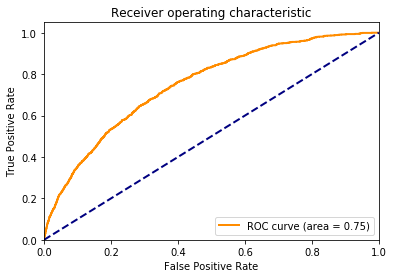

In [276]:
plt.figure()
plt.plot(fpr[1], tpr[1], color='darkorange', lw=2, label=f'ROC curve (area = {np.round(roc_auc[1],2)})')
plt.plot([0,1], [0,1], color='navy', lw=2, linestyle='--')
plt.xlim([0,1])
plt.ylim([0,1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc='lower right')
plt.show()

In [282]:
# That does not look bad at all, our model definitely has predictive power!


diff = tpr[1] - fpr[1]
index = list(diff).index(max(diff))

tpr_final = tpr[1][index]
fpr_final = fpr[1][index]

print(f'our model correctly identifies a pro {np.round(tpr_final,2)} of the time, and {np.round(fpr_final,2)} of the time, the pro prediction is incorrect!')


our model correctly identifies a pro 0.72 of the time, and 0.36 of the time, the pro prediction is incorrect!


# Why did we go with Youden's J Statistic?

This measure of finding the 'best' model is general data-science wisdom. (i.e. compute Youden’s J statistic. from the ROC curve) And it makes sense intuitively; we want to pick a threshold that will get us as close as possible to a TPR = 100% and FPR = 0%. Conceptually, this makes sense, since we want a model that can accuracy identify pro-like behavior, and at the same time be conservative at predicting amateurs as pros.

We briefly covered this in the slides, but what will in the end be useful to us are meaningful False Positives, as these will be the the amateurs that may have genuine pro-player potential. To get to a point where these examples are useful, we need a model that can recognise an actual pro when it sees one (such that we can say when it misclassifies an amateur as a pro it is not the model that is wrong, but the amateur!), but not give us so many suggestions of pros that we are inundated with with amateurs we would manually have to sift through.

Bear in mind also, that, if the data was balanced, my recommendation would probably have been to decide to choose a much higher True Positive rate compared to False Positive rate; the rationale for this would be that we can tolerate sifting through more amateurs if we correctly identify some pros in the process, but the dataset is already unbalanced 50:1 in favour of amateurs, therefore we are already weighting the likelihood of finding a pro as 50 times more valuable than correctly identifying an amateur. Intuitively this feels about right as it is - if I was working as a talent scout and knew that every 50 suggested players I would be likely to come across one with real pro-player potential, this is about where I would draw the line!



In [284]:
threshold = _[index]
threshold

0.844719035575828

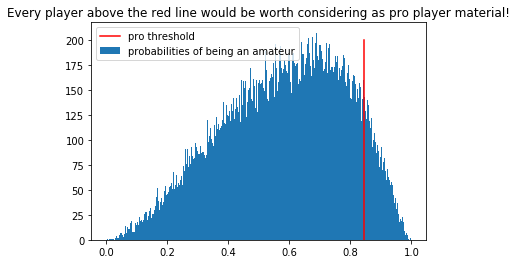

In [291]:
plt.figure()
plt.hist([item[0] for item in y_proba], bins = 500, label='probabilities of being an amateur')
plt.plot([threshold,threshold], [0,200], c='r', label='pro threshold')
plt.title('Every player above the red line would be worth considering as pro player material!')
plt.legend()
plt.show()

In [305]:
# let's look at feature importances: These are all normalised so they can be directly compared!

importances = pd.DataFrame(clf.coef_, columns=summaries_numeric.drop(columns=['pro_flag']).columns).T
importances.rename(columns={0: 'raw_importances'}, inplace=True)
importances['absolute_importance'] = np.abs(importances['raw_importances'])

with pd.option_context('display.max_rows', None, 'display.max_columns', 5):
    display(importances.sort_values(by='absolute_importance', ascending=False))

,raw_importances,absolute_importance
visionWardsBoughtInGame,16.261189,16.261189
timePlayed,-10.554535,10.554535
itemsPurchased,8.487136,8.487136
wardsPlaced,8.116883,8.116883
totalMinionsKilled,8.008075,8.008075
neutralMinionsKilled,5.282986,5.282986
consumablesPurchased,4.364253,4.364253
goldEarned,3.860353,3.860353
totalHealsOnTeammates,3.840492,3.840492
totalHeal,-3.647109,3.647109


# All of the features make intuitive sense! 

The top feature by far was how many vision wards were purchased (a specific relating to how much of the map you can see), which completely makes sense - pro players value being able to see more of the map very highly.

It is also interesting to see how far down the pack the 'damage dealt' figure is - common wisdom says this is one of, if not the most important characteristic, but it doesn't seem to be that important for determining a pro!

Interestingly time played (or game length) comes out in number 2, with a strong negative correlation, showing that pros end games faster than amateurs. This is very much in line with the feature engineering that was done

The three features I created appear somewhere in the middle of the pack; not useless but not that useful either. I strongly suspect that if more of these values were populated (only ~20k/500k values were populated in the summaries table) the data would be more useful; it is likely there simply wasn't enough to base the entire classifier on it.

Before doing this modelling my assumption was that the role (Top, Middle, Jungle, etc) would make a big difference in identifying whether a player was professional or not since different roles have very different playstyles. It is interesting that this does not come up as an important feature here, though I would still like to test this hypothesis and build 5 separate logistic regressions given that the process is now done just to validate!

# Let's build a classifier on a each of the roles to see if the importances / ROC AUC scores materially change. 

The feature importances gathered above tell us that selecting a specific role should not have a significant impact, but I'm so surprised by this I'd like to check!

################################### BOTTOM stats ##################################


/Users/natalia/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/Users/natalia/anaconda3/lib/python3.7/site-packages/sklearn/utils/__init__.py:806: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return floored.astype(np.int)
/Users/natalia/anaconda3/lib/python3.7/site-packages/sklearn/uti

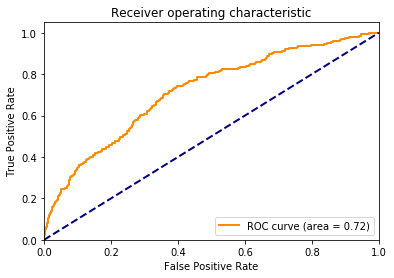

our model correctly identifies a pro 0.71 of the time, and 0.36 of the time, the pro prediction is incorrect!


,raw_importances,absolute_importance
timePlayed,-16.318904,16.318904
activity_feature,9.367742,9.367742
totalMinionsKilled,8.823262,8.823262
wardsPlaced,6.791675,6.791675
damageSelfMitigated,6.183318,6.183318
...,...,...
largestCriticalStrike,-0.024493,0.024493
totalUnitsHealed,-0.020271,0.020271
nexusKills,-0.017654,0.017654
unrealKills,0.000000,0.000000


################################### JUNGLE stats ##################################


/Users/natalia/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/Users/natalia/anaconda3/lib/python3.7/site-packages/sklearn/utils/__init__.py:806: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return floored.astype(np.int)
/Users/natalia/anaconda3/lib/python3.7/site-packages/sklearn/uti

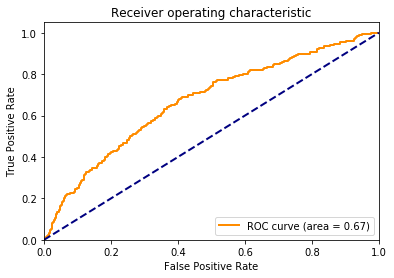

our model correctly identifies a pro 0.69 of the time, and 0.41 of the time, the pro prediction is incorrect!


,raw_importances,absolute_importance
wardsPlaced,13.699079,13.699079
visionWardsBoughtInGame,10.047617,10.047617
consumablesPurchased,-8.031682,8.031682
itemsPurchased,7.958723,7.958723
timePlayed,-7.610020,7.610020
...,...,...
bountyLevel,-0.039549,0.039549
firstTowerAssist,-0.037166,0.037166
largestMultiKill,-0.028725,0.028725
sightWardsBoughtInGame,0.000000,0.000000


################################### TOP stats ##################################


/Users/natalia/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/Users/natalia/anaconda3/lib/python3.7/site-packages/sklearn/utils/__init__.py:806: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return floored.astype(np.int)
/Users/natalia/anaconda3/lib/python3.7/site-packages/sklearn/uti

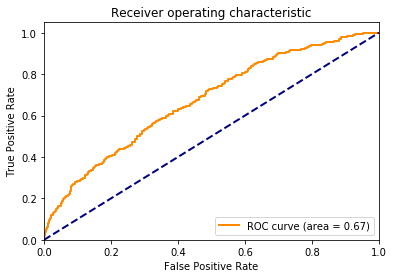

our model correctly identifies a pro 0.57 of the time, and 0.33 of the time, the pro prediction is incorrect!


,raw_importances,absolute_importance
jungle_death_feature,10.883427,10.883427
timePlayed,-9.668307,9.668307
consumablesPurchased,9.232712,9.232712
totalMinionsKilled,6.431445,6.431445
detectorWardsPlaced,6.253380,6.253380
...,...,...
nexusLost,-0.013084,0.013084
participantId,0.010142,0.010142
bountyLevel,-0.001135,0.001135
unrealKills,0.000000,0.000000


################################### UTILITY stats ##################################


/Users/natalia/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/Users/natalia/anaconda3/lib/python3.7/site-packages/sklearn/utils/__init__.py:806: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return floored.astype(np.int)
/Users/natalia/anaconda3/lib/python3.7/site-packages/sklearn/uti

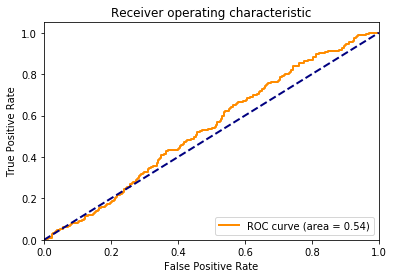

our model correctly identifies a pro 0.84 of the time, and 0.74 of the time, the pro prediction is incorrect!


,raw_importances,absolute_importance
activity_feature,-14.988972,14.988972
itemsPurchased,14.959615,14.959615
consumablesPurchased,8.940992,8.940992
timePlayed,-7.755779,7.755779
building_kill_feature,6.593892,6.593892
...,...,...
win,-0.020915,0.020915
firstTowerAssist,0.019835,0.019835
nexusLost,-0.016454,0.016454
unrealKills,0.000000,0.000000


################################### MIDDLE stats ##################################


/Users/natalia/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/Users/natalia/anaconda3/lib/python3.7/site-packages/sklearn/utils/__init__.py:806: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return floored.astype(np.int)
/Users/natalia/anaconda3/lib/python3.7/site-packages/sklearn/uti

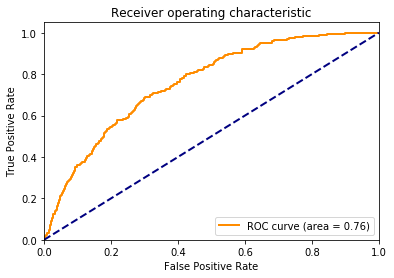

our model correctly identifies a pro 0.69 of the time, and 0.3 of the time, the pro prediction is incorrect!


,raw_importances,absolute_importance
totalMinionsKilled,11.679049,11.679049
timePlayed,-10.815872,10.815872
totalDamageDealt,-9.076423,9.076423
goldEarned,8.274500,8.274500
totalHealsOnTeammates,7.746806,7.746806
...,...,...
nexusTakedowns,-0.017258,0.017258
turretsLost,-0.006529,0.006529
firstBloodAssist,0.006272,0.006272
largestCriticalStrike,0.000979,0.000979


In [346]:
for role in ['BOTTOM', 'JUNGLE', 'TOP', 'UTILITY','MIDDLE']:
    
    print(f'################################### {role} stats ##################################')

    summaries_numeric_mid = summaries_numeric.loc[summaries_numeric[role] == 1]
    summaries_numeric_mid.drop(columns=['BOTTOM', 'JUNGLE', 'Invalid', 'TOP', 'UTILITY','MIDDLE'], inplace=True)

    x_train_mid, x_test_mid, y_train_mid, y_test_mid = train_test_split(summaries_numeric_mid.drop(columns=['pro_flag']),
                                                        summaries_numeric_mid['pro_flag'],
                                                        test_size=0.1, 
                                                        random_state=42,
                                                        shuffle=True,
                                                        stratify=summaries_numeric_mid['pro_flag'])

    # now let's make our minmaxscaler on our train data

    scaler = MinMaxScaler()
    x_scaler_mid = scaler.fit(x_train_mid)

    x_train_scaled_mid = scaler.transform(x_train_mid)
    x_test_scaled_mid = scaler.transform(x_test_mid)

    clf_mid = LogisticRegression(random_state=42, class_weight={0:1, 1:45})
    clf_mid.fit(x_train_scaled_mid, y_train_mid)
    y_proba_mid = clf.predict_proba(x_test_scaled_mid)

    y_test_binarised_mid = label_binarize(y_test_mid, classes=[0,1,2])

    fpr_mid = dict()
    tpr_mid = dict()
    roc_auc_mid = dict()

    for i in range(2):
        fpr_mid[i], tpr_mid[i], _ = roc_curve(y_test_binarised_mid[:, i], y_proba_mid[:, i])
        roc_auc_mid[i] = auc(fpr_mid[i] , tpr_mid[i])

    fpr_mid['micro'], tpr_mid['micro'], _ = roc_curve(np.array([list(item[0:2]) for item in y_test_binarised_mid]).ravel(), 
                                              y_proba_mid.ravel())
    roc_auc_mid['micro'] = auc(fpr_mid['micro'], tpr_mid['micro'])

    plt.figure()
    plt.plot(fpr_mid[1], tpr_mid[1], color='darkorange', lw=2, label=f'ROC curve (area = {np.round(roc_auc_mid[1],2)})')
    plt.plot([0,1], [0,1], color='navy', lw=2, linestyle='--')
    plt.xlim([0,1])
    plt.ylim([0,1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc='lower right')
    plt.show()

    # That looks very similar to the previous logistic regression! Let's see the tpr and fpr's

    diff_mid = tpr_mid[1] - fpr_mid[1]
    index_mid = list(diff_mid).index(max(diff_mid))

    tpr_final_mid = tpr_mid[1][index_mid]
    fpr_final_mid = fpr_mid[1][index_mid]

    print(f'our model correctly identifies a pro {np.round(tpr_final_mid,2)} of the time, and {np.round(fpr_final_mid,2)} of the time, the pro prediction is incorrect!')

    # let's look at feature importances: These are all normalised so they can be directly compared!

    importances_mid = pd.DataFrame(clf_mid.coef_, columns=summaries_numeric_mid.drop(columns=['pro_flag']).columns).T
    importances_mid.rename(columns={0: 'raw_importances'}, inplace=True)
    importances_mid['absolute_importance'] = np.abs(importances_mid['raw_importances'])

    with pd.option_context('display.max_rows', 10, 'display.max_columns', 5):
        display(importances_mid.sort_values(by='absolute_importance', ascending=False))


# These results are really interesting!

There's too much information here to briefly talk through in one notebook. But, some takeaway points are:

- It turns out this method is awful at predicting the 'utility' role - so we shouldn't expect to see any of those when we come to use it (which I find pretty funny, since it's the role that absolutely nobody wants to play). It's best at predicting midlaners
- Though my features created from the timelines data didn't end up being useful in the overall model, they show up a few times in the role-specific models, which is great to see!

### At the risk of this notebook getting too long, let's try out one more model, XGBoost (a kaggle favourite & heavyweight) on the entire dataset and see if we can improve our results at all 

**Notes**
- I won't spend any time on hyperparam optimisation since it's basically a random search across many different params and I'm running out of time - will just use the out of the box values provided by xgboost), except for the unbalanced data one, just need to put the ratio of 50:1 in for that
- I haven't used KFoldCrossValidation in this notebook since it takes ages to run, but in the real world I'd do that too, hopefully by now I've convinced you I would know how to do that :D

# the only thing we need to change is our classifier. 

If we needed to reuse the code below any more I'd make a function/ sklearn pipeline, but it's the last time we need it now so we should be good.

`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
The use of label encoder in XGBClassifier is deprecated 

[01:58:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


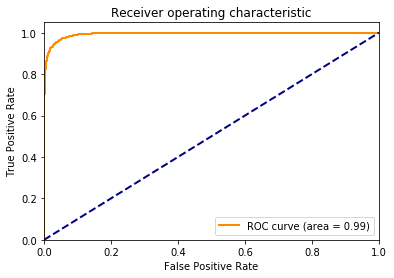

our model correctly identifies a pro 0.97 of the time, and 0.05 of the time, the pro prediction is incorrect!
our threshold value is 0.9998534917831421


In [375]:
summaries_numeric_mid = summaries_numeric

x_train_mid, x_test_mid, y_train_mid, y_test_mid = train_test_split(summaries_numeric_mid.drop(columns=['pro_flag']),
                                                    summaries_numeric_mid['pro_flag'],
                                                    test_size=0.1, 
                                                    random_state=42,
                                                    shuffle=True,
                                                    stratify=summaries_numeric_mid['pro_flag'])

# now let's make our minmaxscaler on our train data

scaler = MinMaxScaler()
x_scaler_mid = scaler.fit(x_train_mid)

x_train_scaled_mid = scaler.transform(x_train_mid)
x_test_scaled_mid = scaler.transform(x_test_mid)

clf_mid = xgb.XGBClassifier(scale_pos_weight=50, random_state=42)
clf_mid.fit(x_train_scaled_mid, y_train_mid)
y_proba_mid = clf_mid.predict_proba(x_test_scaled_mid)

y_test_binarised_mid = label_binarize(y_test_mid, classes=[0,1,2])

fpr_mid = dict()
tpr_mid = dict()
roc_auc_mid = dict()

for i in range(2):
    fpr_mid[i], tpr_mid[i], _ = roc_curve(y_test_binarised_mid[:, i], y_proba_mid[:, i])
    roc_auc_mid[i] = auc(fpr_mid[i] , tpr_mid[i])

fpr_mid['micro'], tpr_mid['micro'], _ = roc_curve(np.array([list(item[0:2]) for item in y_test_binarised_mid]).ravel(), 
                                          y_proba_mid.ravel())
roc_auc_mid['micro'] = auc(fpr_mid['micro'], tpr_mid['micro'])

plt.figure()
plt.plot(fpr_mid[1], tpr_mid[1], color='darkorange', lw=2, label=f'ROC curve (area = {np.round(roc_auc_mid[1],2)})')
plt.plot([0,1], [0,1], color='navy', lw=2, linestyle='--')
plt.xlim([0,1])
plt.ylim([0,1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc='lower right')
plt.show()

# That looks very similar to the previous logistic regression! Let's see the tpr and fpr's

diff_mid = tpr_mid[1] - fpr_mid[1]
index_mid = list(diff_mid).index(max(diff_mid))

tpr_final_mid = tpr_mid[1][index_mid]
fpr_final_mid = fpr_mid[1][index_mid]

print(f'our model correctly identifies a pro {np.round(tpr_final_mid,2)} of the time, and {np.round(fpr_final_mid,2)} of the time, the pro prediction is incorrect!')
print(f'our threshold value is {_[index_mid]}')

# WOW! THIS SEEMS TOO GOOD TO BE TRUE

Do I have a data leak somewhere? Let's look at what the model is using to be this good using a python implementation of shapley values, shap

100%|===================| 519051/519230 [14:08<00:00]        

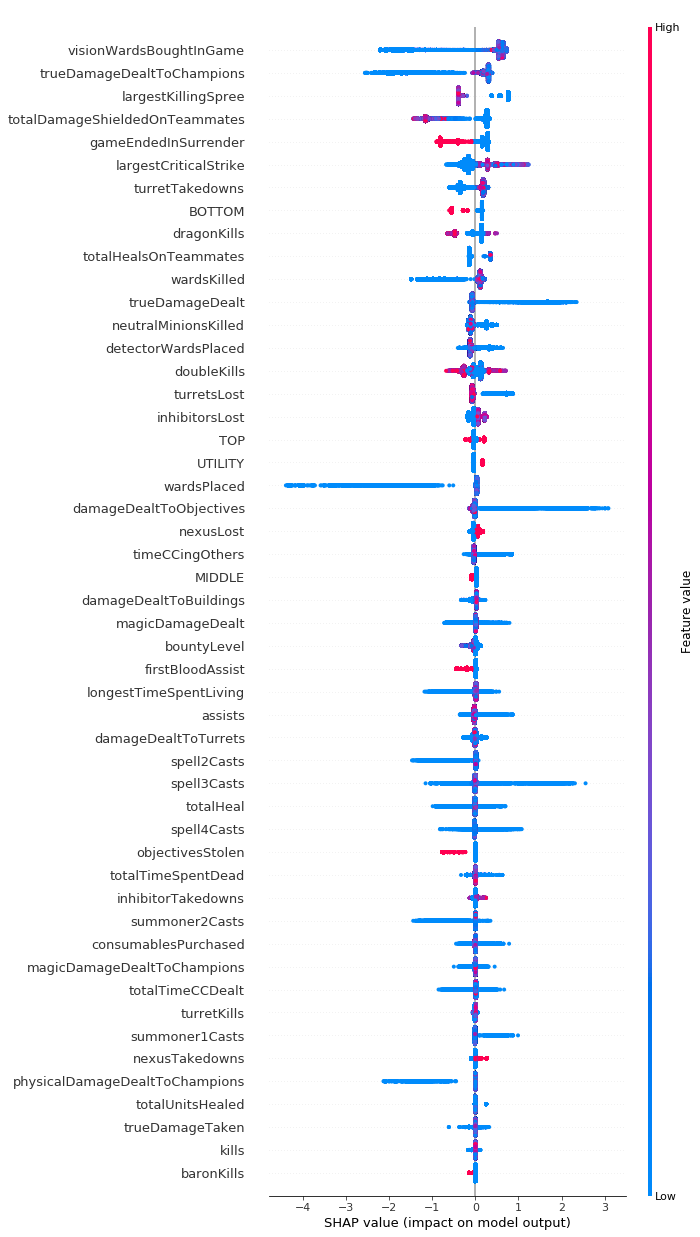

In [364]:
explainer = shap.TreeExplainer(clf_mid, data=summaries_numeric_mid.drop(columns=['pro_flag']))
shap_values = explainer.shap_values(summaries_numeric_mid.drop(columns=['pro_flag']))
shap.summary_plot(shap_values, summaries_numeric_mid.drop(columns=['pro_flag']), max_display=50)

Vision wards consistently show up as the best indicator of whether or not a player is pro or not, in line with the logistic regression stuff. In general I can't see any data leak - let's check what the training data's ROC curve

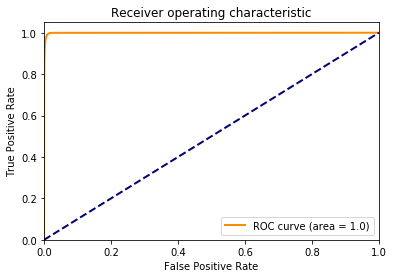

our model correctly identifies a pro 1.0 of the time, and 0.01 of the time, the pro prediction is incorrect!


In [371]:
# let's compare this to test results just to make sure.....

y_proba_mid = clf_mid.predict_proba(x_train_scaled_mid)

y_test_binarised_mid = label_binarize(y_train_mid, classes=[0,1,2])

fpr_mid = dict()
tpr_mid = dict()
roc_auc_mid = dict()

for i in range(2):
    fpr_mid[i], tpr_mid[i], _ = roc_curve(y_test_binarised_mid[:, i], y_proba_mid[:, i])
    roc_auc_mid[i] = auc(fpr_mid[i] , tpr_mid[i])

fpr_mid['micro'], tpr_mid['micro'], _ = roc_curve(np.array([list(item[0:2]) for item in y_test_binarised_mid]).ravel(), 
                                          y_proba_mid.ravel())
roc_auc_mid['micro'] = auc(fpr_mid['micro'], tpr_mid['micro'])

plt.figure()
plt.plot(fpr_mid[1], tpr_mid[1], color='darkorange', lw=2, label=f'ROC curve (area = {np.round(roc_auc_mid[1],2)})')
plt.plot([0,1], [0,1], color='navy', lw=2, linestyle='--')
plt.xlim([0,1])
plt.ylim([0,1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc='lower right')
plt.show()

# That looks very similar to the previous logistic regression! Let's see the tpr and fpr's

diff_mid = tpr_mid[1] - fpr_mid[1]
index_mid = list(diff_mid).index(max(diff_mid))

tpr_final_mid = tpr_mid[1][index_mid]
fpr_final_mid = fpr_mid[1][index_mid]

print(f'our model correctly identifies a pro {np.round(tpr_final_mid,2)} of the time, and {np.round(fpr_final_mid,2)} of the time, the pro prediction is incorrect!')

Well as expected this performs much better - it may well be that we've got a very good predictor of whether a player is a pro or not... very useful!